# Plotting a stock's price chart with corporate action overlay

Sometimes, a picture is worth a thousand words.

In [1]:
library(tidyverse)
library(ggthemes)
library(reshape2)
library(odbc)
library(RPostgres)
library(plutoR)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

#initialize
equitiesIndiaNse <- EquitiesIndiaNse()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults

In [2]:
symbol <- "ASHOKLEY"
startDt <- as.Date(Sys.Date() - 10*365) #N-year chart
endDt <- Sys.Date()

# examples: https://github.com/shyams80/plutons/blob/master/docs-R/EquitiesIndiaNse.ipynb

#make sure that the data exists

equitiesIndiaNse$EodTimeSeries() %>%
    filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt 
           & SYMBOL == symbol 
           & (SERIES == 'EQ' | SERIES == 'BE')) %>%
    summarize(MAX_DT = max(TIME_STAMP), MIN_DT = min(TIME_STAMP)) %>%
    print()

equitiesIndiaNse$EodAdjustedTimeSeries() %>%
    filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt 
           & SYMBOL == symbol) %>%
    summarize(MAX_DT = max(TIME_STAMP), MIN_DT = min(TIME_STAMP)) %>%
    print()


Warning message:
“Missing values are always removed in SQL.
Use `MAX(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”Warning message:
“Missing values are always removed in SQL.
Use `MIN(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

# Source:   lazy query [?? x 2]
# Database: Microsoft SQL Server 13.00.4259[ro1@NORWAY/StockViz]
  MAX_DT     MIN_DT    
  <date>     <date>    
1 2019-07-30 2009-08-03
# Source:   lazy query [?? x 2]
# Database: postgres [ro1@SWEDEN:5432/StockVizDyn]
  MAX_DT     MIN_DT    
  <date>     <date>    
1 2019-07-30 2009-08-03


In [3]:
# so the data exists in both so we can use the EodAdjustedTimeSeries

eodPxDf <- equitiesIndiaNse$EodAdjustedTimeSeries() %>%
    filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt & SYMBOL == symbol) %>%
    select(TIME_STAMP, CLOSE) %>%
    arrange(TIME_STAMP) %>%
    collect() %>%
    as.data.frame()

print("HEAD:")
print(head(eodPxDf))
print("TAIL:")
print(tail(eodPxDf))
print("SUMMARY:")
print(summary(eodPxDf$CLOSE))

[1] "HEAD:"
  TIME_STAMP  CLOSE
1 2009-08-03 14.050
2 2009-08-04 13.625
3 2009-08-05 13.500
4 2009-08-06 12.625
5 2009-08-07 12.250
6 2009-08-10 12.250
[1] "TAIL:"
     TIME_STAMP CLOSE
2457 2019-07-23 75.00
2458 2019-07-24 72.55
2459 2019-07-25 72.30
2460 2019-07-26 74.20
2461 2019-07-29 71.65
2462 2019-07-30 70.20
[1] "SUMMARY:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.82   20.95   31.68   54.57   84.77  156.15 


In [4]:
corpActDf <- equitiesIndiaNse$CorporateActions() %>%
    filter(EX_DATE >= startDt & EX_DATE <= endDt & SYMBOL == symbol & SERIES == 'EQ') %>%
    select(T = EX_DATE, PURPOSE) %>%
    collect() %>%
    group_by(T) %>%
    mutate(PURPOSE = paste0(PURPOSE, collapse='/')) %>%
    as.data.frame()
    
corpEvtDf <- equitiesIndiaNse$CorporateEvents() %>%
    filter(EVENT_DATE >= startDt & EVENT_DATE <= endDt & SYMBOL == symbol) %>%
    select(T = EVENT_DATE, PURPOSE) %>%
    collect() %>%
    group_by(T) %>%
    mutate(PURPOSE = paste0(PURPOSE, collapse='/')) %>%
    as.data.frame()

print(corpActDf)
print(corpEvtDf)

            T                                                        PURPOSE
1  2011-06-29           ANNUAL GENERAL MEETING AND DIVIDEND RS.2/- PER SHARE
2  2011-08-02                                                      BONUS 1:1
3  2012-07-12           ANNUAL GENERAL MEETING AND DIVIDEND RE.1/- PER SHARE
4  2010-07-16          ANNUAL GENERAL MEETING AND DIVIDEND RS.1.50 PER SHARE
5  2013-07-04 ANNUAL GENERAL MEETING / DIVIDEND - RE.0.60/- PER EQUITY SHARE
6  2014-07-18                                         ANNUAL GENERAL MEETING
7  2015-06-17            ANNUAL GENERAL MEETING/DIVIDEND - RE 0.45 PER SHARE
8  2016-07-13              ANNUAL GENERAL MEETING/DIVIDEND RE 0.95 PER SHARE
9  2017-07-11          ANNUAL GENERAL MEETING/DIVIDEND - RS 1.56/- PER SHARE
10 2018-07-09                                    DIVIDEND- RS 2.43 PER SHARE
11 2019-07-23           ANNUAL GENERAL MEETING/ DIVIDEND - RS 3.10 PER SHARE
            T                                           PURPOSE
1  2017-05-2

In [5]:
startDate <- first(eodPxDf$TIME_STAMP)
endDate <- last(eodPxDf$TIME_STAMP)

xAxisTicks <- seq(from=startDate, to=endDate, length.out=10)

### Price chart (log of close)

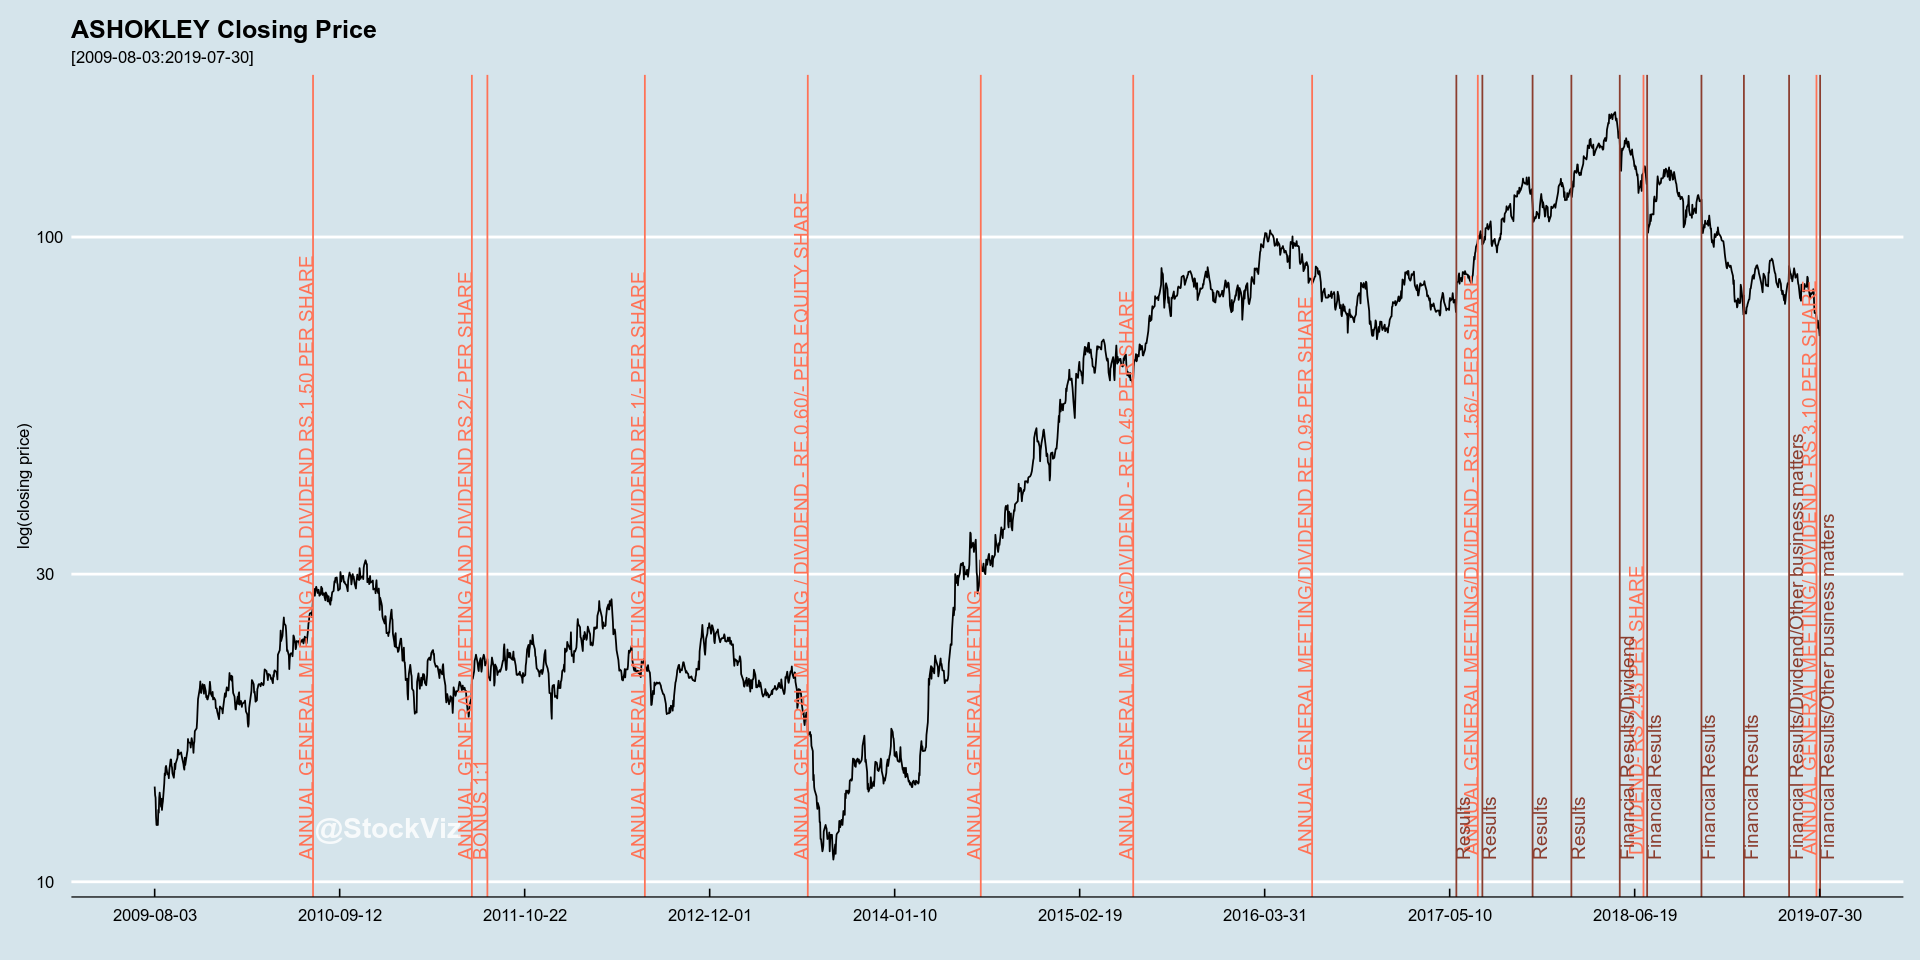

In [6]:
ggplot(eodPxDf, aes(x = TIME_STAMP, y = CLOSE)) + 
    theme_economist() +
    geom_line() + 
    geom_vline(xintercept = corpActDf$T, colour="coral1") +
    annotate("text", x = corpActDf$T, y = min(eodPxDf$CLOSE, na.rm=T), label = corpActDf$PURPOSE,
            col='coral1', cex = 4, angle = 90, hjust = 0, vjust=0) +
    geom_vline(xintercept = corpEvtDf$T, colour="coral4") +
    annotate("text", x = corpEvtDf$T, y = min(eodPxDf$CLOSE, na.rm=T), label = corpEvtDf$PURPOSE,
            col='coral4', cex = 4, angle = 90, hjust = 0, vjust=1) +
    scale_y_log10() +
    scale_x_date(breaks = xAxisTicks) +
    labs(x='', y='log(closing price)', fill='', color='',
         title=sprintf("%s Closing Price", symbol), 
         subtitle=sprintf("[%s:%s]", startDate, endDate)) +
    annotate("text", x=startDate, y=min(eodPxDf$CLOSE, na.rm=T), label = "@StockViz", 
             hjust=-1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

### Cumulative returns and drawdowns

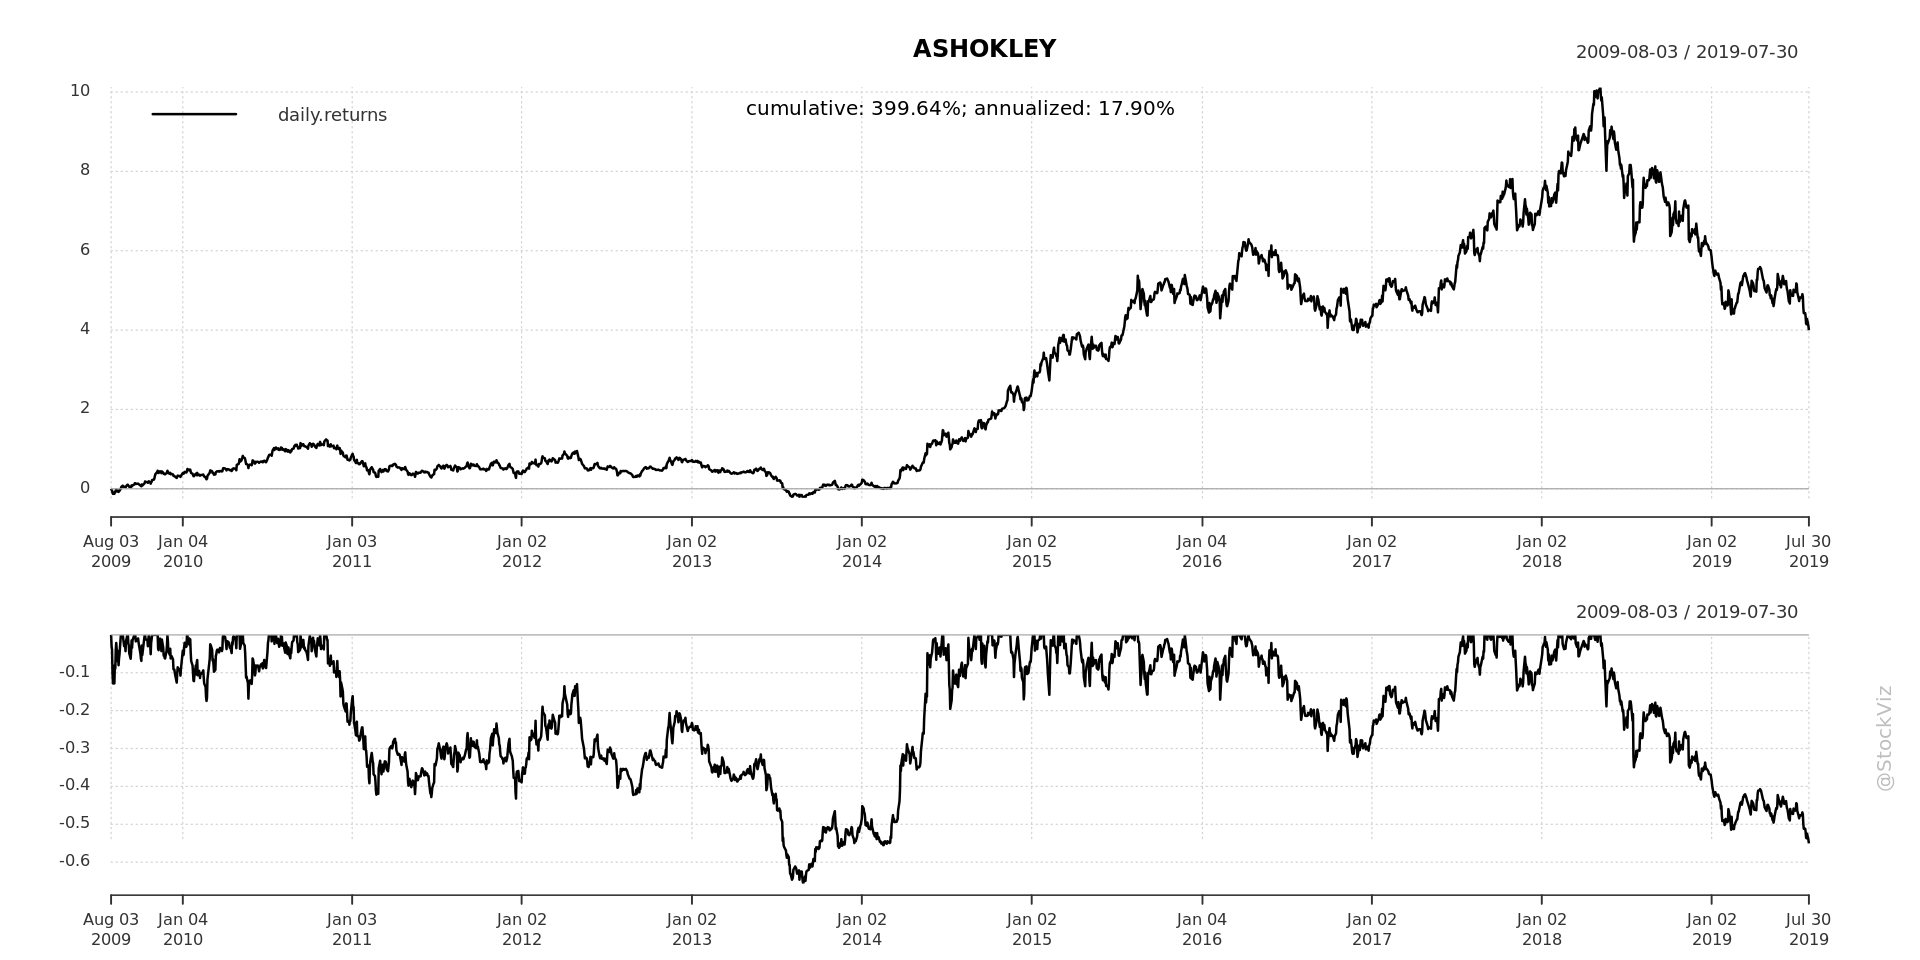

In [7]:
dailies <- dailyReturn(xts(eodPxDf$CLOSE, eodPxDf$TIME_STAMP))
Common.PlotCumReturns(dailies, symbol, NA)

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)